In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
from keras.models import Sequential
from keras.layers.core import Dense,Flatten,Activation,Lambda
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

#I have edited to excel such that i have deleted 0 angle data at source, Total 0 angle 
#data at source is 1000 fields 
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
index = samples.pop(0)

print(index[0])

Using TensorFlow backend.


center


In [2]:
# Example of using .flow(X, y):
import skimage.transform as skimg
from skimage.transform import resize
from keras import models, optimizers, backend
from keras.layers import ELU,convolutional,Convolution2D, MaxPooling2D,pooling,core
from keras.layers import Activation, Dropout, Flatten, Dense ,Lambda,Cropping2D
from keras import backend
from keras.layers.normalization import BatchNormalization


In [3]:
# Split records in validation and trainig set 
# Split records in validation and trainig set 
str_src = './data/IMG/'
shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print("Samples total",len(samples))
print("validation_samples",len(validation_samples))
print("")
print("train_samples",len(train_samples))
print("")
print("center image name",train_samples[10][0])
print("")
print("angle",train_samples[10][1])
print("")
name = str_src+train_samples[10][0].split('/')[-1]
print("ip file name",name)
print("")
img = cv2.imread(name)
img_shape = img.shape
print("ip img shape",img_shape)
print("")
samples = None





Samples total 8832
validation_samples 1767

train_samples 7065

center image name IMG/center_2016_12_01_13_38_57_124.jpg

angle  IMG/left_2016_12_01_13_38_57_124.jpg

ip file name ./data/IMG/center_2016_12_01_13_38_57_124.jpg

ip img shape (160, 320, 3)



In [4]:
# 1op shape after conv 32 of 1 x1 (None, 30, 30, 24)
# 1op shape after conv 32 of 5 x5 (None, 26, 26, 36)
# 3op shape after conv 16 of 3 x3 (None, 6, 6, 48)
# 4op shape after conv 16 of 3 x3 (None, 4, 4, 64)
# flatten (None, 1024)
# Epoch 1/1

In [5]:
def get_model():
    model = Sequential()
    
    model.add(Convolution2D(24, 5, 5, input_shape=(64, 64, 3),subsample=(2, 2), border_mode="valid"))
    model.add(BatchNormalization())
    model.add(ELU())
    print("1op shape after conv 32 of 1 x1",model.output_shape)
    # layer 1 output shape is 30x30x24
    model.add(Convolution2D(36, 5, 5))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(.2))
    print("2op shape after conv 32 of 5 x5",model.output_shape)
    # layer 2 output shape is 26x26x36
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="valid"))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(.4))
    model.add(MaxPooling2D((2, 2), border_mode='valid'))
    print("3op shape after conv 16 of 3 x3",model.output_shape)
     # layer 3 output shape is 6x6x48
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(.4))
     # layer 4 output shape is 4x4x64
    print("4op shape after conv 16 of 3 x3",model.output_shape)
    model.add(Flatten())
    print("flatten",model.output_shape)
    model.add(core.Dense(1024))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(core.Dense(512))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(core.Dense(10))
    model.add(Dense(1))
   
    return model

In [6]:


def crop_and_resize(image):
    
    cropped_image = image[40:140, 10:310, :]
    processed_image = cv2.resize(image, (64,64))
    return processed_image


def preprocess_image(image):
    image = crop_and_resize(image)
    image = image.astype(np.float32)

    #Normalize image
    image = image/255.0 - 0.5
    return image

In [7]:
def augment_brightness_camera_images(image):
    
    
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [8]:
from keras.preprocessing.image import img_to_array, load_img
def get_augmented_data(sample):
    #print(sample)
    steering = float(sample[3])

    # randomly choose the camera to take the image from
    camera = np.random.choice([0, 1, 2])

    # adjust the steering angle for left anf right cameras
    if camera == 1:
        steering += 0.25
    elif camera == 2:
        steering -= 0.25   
    fname = str_src+sample[camera].split('/')[-1]
    image = load_img(fname)
    image = img_to_array(image)
    
    # flip the images 
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        steering = -1*steering
        image = cv2.flip(image,1)
    
    
     # Apply brightness augmentation
    image = augment_brightness_camera_images(image)

    # Crop, resize and normalize the image
    image = preprocess_image(image)
    return image, steering

    

In [9]:
def get_data(sample):
    steering = float(sample[3])

    # randomly choose the camera to take the image from
    camera = np.random.choice([0, 1, 2])

    # adjust the steering angle for left anf right cameras
    if camera == 1:
        steering += 0.25
    elif camera == 2:
        steering -= 0.25
    fname = str_src+sample[camera].split('/')[-1]
    image = load_img(fname)
    image = img_to_array(image)
    
    
    # Crop, resize and normalize the image
    image = preprocess_image(image)
    return image, steering

In [10]:
import skimage.transform as skimg
from skimage.transform import resize
def generator(data_sample,augment = False,  batch_size=32):
    num_samples = len(data_sample)
    batches_per_epoch = num_samples// batch_size

    i = 0
    while(True):
        start = i*batch_size
        end = start+batch_size - 1

        X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        index_batch = 0
        # slice a `batch_size` sized chunk from the dataframe
        # and generate augmented data for each row in the chunk on the fly
        for row in data_sample[start:end]:
            #print(index_batch)
            if(row):
                if(augment):

                    X_batch[index_batch], y_batch[index_batch] = get_augmented_data(row)
                    index_batch = index_batch+1
                else:
                    X_batch[index_batch], y_batch[index_batch] = get_data(row)
                    index_batch = index_batch+1

        i += 1
        if i == batches_per_epoch - 1:
            # reset the index so that we can cycle over the data_frame again
            i = 0
        yield X_batch, y_batch


In [11]:
BATCH_SIZE = 32
train_generator = generator(train_samples,augment = True, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, augment = False,batch_size=BATCH_SIZE)

In [12]:

model = get_model()
samples_per_epoch = (24000//BATCH_SIZE)*BATCH_SIZE
#print(samples_per_epoch)


model.compile(optimizer=optimizers.Adam(lr=1e-04), loss='mean_squared_error')
    

history_object = model.fit_generator(train_generator, validation_data=validation_generator,
                                         samples_per_epoch= samples_per_epoch,  
        nb_val_samples=3000, nb_epoch=5,verbose=1)
# history_object = model.fit_generator(train_generator, samples_per_epoch= 
#         len(train_samples), validation_data=validation_generator, 
#         nb_val_samples=len(validation_samples), nb_epoch=3,verbose=1)

model.save('model_24k.h5')    
with open('model.json', 'w') as outfile:
    outfile.write(model.to_json())
backend.clear_session()
print("done")

1op shape after conv 32 of 1 x1 (None, 30, 30, 24)
2op shape after conv 32 of 5 x5 (None, 26, 26, 36)
3op shape after conv 16 of 3 x3 (None, 6, 6, 48)
4op shape after conv 16 of 3 x3 (None, 4, 4, 64)
flatten (None, 1024)
Epoch 1/5
24000/24000 [==============================] - 797s - loss: 0.2791 - val_loss: 0.0536

dict_keys(['loss', 'val_loss'])


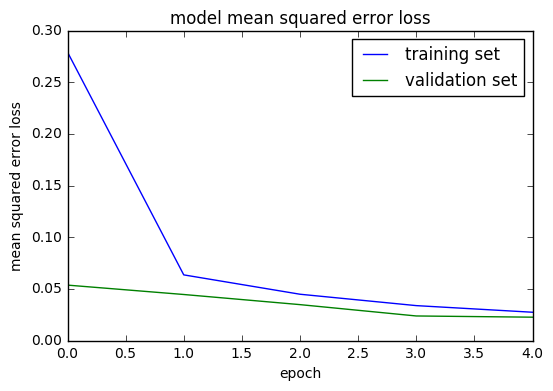

In [18]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [14]:
#   print(model.output_shape)
#     model.add(convolutional.Convolution2D(8, 1, 1))
#     model.add(BatchNormalization())
#     model.add(Activation('tanh'))
#    # model.add(MaxPooling2D((2,2)))
#     #model.add(Dropout(0.5))
#     print("op shape after conv 8 of 1 x1",model.output_shape)
#     model.add(convolutional.Convolution2D(16, 3, 3))
#     model.add(BatchNormalization())
#     model.add(Activation('tanh'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Dropout(0.5))
#     print("op shape after conv 16 of 3 x3",model.output_shape)
#     model.add(convolutional.Convolution2D(32, 3, 3))
#     model.add(BatchNormalization())
#     model.add(Activation('tanh'))
#     model.add(MaxPooling2D((2,2)))
#     model.add(Dropout(0.5))
#     print("op shape after conv 32 of 3 x3",model.output_shape)

#     model.add(Flatten())
#     print(model.output_shape)

#     model.add(core.Dense(1024))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Activation('tanh'))
#     model.add(core.Dense(512))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Activation('tanh'))
#     #model.add(core.Dense(10))
#     model.add(Dense(1))
#     return model

In [15]:
# import skimage.transform as skimg
# from skimage.transform import resize
# def generator(data_sample,augment = False,  batch_size=32):
#     num_samples = len(data_sample)
#     print("num_samples",num_samples)
#     while 1: # Loop forever so the generator never terminates
#         #shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = data_sample[offset:offset+batch_size]

#             #images = []
#             #angles = []
#             # Output arrays
#             X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
#             y_batch = np.zeros((batch_size,), dtype=np.float32)
#             index_batch = 0 
#             for batch_sample in batch_samples:
#                 #print(index_batch)
#                 if(augment):
#                     X_batch[index_batch], y_batch[index_batch] = get_augmented_data(batch_sample)
#                     index_batch = index_batch+1
#                 else:
#                     X_batch[index_batch], y_batch[index_batch] = get_data(batch_sample)
#                     index_batch = index_batch+1
           
#         yield sklearn.utils.shuffle(X_batch,y_batch)


In [16]:
# def get_model():
#     model = Sequential()
#     # model.add(Lambda(preprocess_batch, input_shape=(160, 320, 3), output_shape=(64, 64, 3)))

#     # layer 1 output shape is 32x32x32
#     model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
#     model.add(ELU())

#     # layer 2 output shape is 15x15x16
#     model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
#     model.add(ELU())
#     model.add(Dropout(.4))
#     model.add(MaxPooling2D((2, 2), border_mode='valid'))

#     # layer 3 output shape is 12x12x16
#     model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
#     model.add(ELU())
#     model.add(Dropout(.4))

#     # Flatten the output
#     model.add(Flatten())

#     # layer 4
#     model.add(Dense(1024))
#     model.add(Dropout(.3))
#     model.add(ELU())

#     # layer 5
#     model.add(Dense(512))
#     model.add(ELU())

#     # Finally a single output, since this is a regression problem
#     model.add(Dense(1))
# #     return mode

In [17]:
#  #valid border mode should get rid of a couple each way, whereas same keeps
#     model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
#     # Use relu (non-linear activation function), not mentioned in Nvidia paper but a standard
#     model.add(Activation('relu'))
#     model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
#     model.add(Activation('relu'))
# #     model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))
# #     model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid'))
#     model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid'))

#     model.add(Flatten())
#     # add in dropout of .5 (not mentioned in Nvidia paper)
#     model.add(Dropout(.5))
#     model.add(Activation('relu'))

#     model.add(Dense(100))
#     # model.add(Dropout(.3))
#     model.add(Activation('relu'))

#     model.add(Dense(50))
#     model.add(Activation('relu'))

#     model.add(Dense(10))
#     model.add(Activation('relu'))

#     model.add(Dense(1))

#     #compile with normal adam optimizer (loss .001) and return
#     #model.compile(loss='mse', optimizer='adam')
#     model.summary()